In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pickle

In [2]:
# Load the dataset
df = pd.read_csv('500_Person_Gender_Height_Weight_Index.csv')
df.head()

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3


## Data Cleaning

In [3]:
# Check the data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Gender  500 non-null    object
 1   Height  500 non-null    int64 
 2   Weight  500 non-null    int64 
 3   Index   500 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 15.8+ KB


In [4]:
# Check missing values in the data
df.isnull().sum().sort_values(ascending=False)

Gender    0
Height    0
Weight    0
Index     0
dtype: int64

In [5]:
# Check the duplicated data
df.duplicated().sum()

11

In [6]:
# Drop the duplicated data
df.drop_duplicates()

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3
...,...,...,...,...
495,Female,150,153,5
496,Female,184,121,4
497,Female,141,136,5
498,Male,150,95,5


<AxesSubplot:ylabel='Weight'>

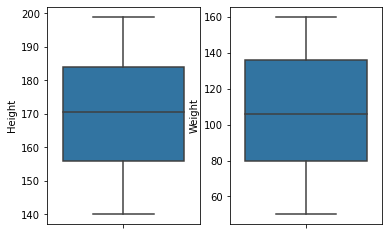

In [8]:
# Check outlier in the data
f, axes = plt.subplots(1, 2)
sns.boxplot(y= df['Height'], ax=axes[0])
sns.boxplot(y = df['Weight'], ax=axes[1])

## Exploratory Data Analysis

In [12]:
# Create pivot table
pivot_table = pd.pivot_table(df, values=['Height', 'Weight','Gender'], index=['Index','Gender'],
                       aggfunc={'Height': "mean", 'Weight': "mean", "Gender": "count"})

In [13]:
pivot_table

Gender      Height      Weight
Index Gender                                
0     Female       7  186.571429   51.857143
      Male         6  188.666667   51.500000
1     Female       7  184.142857   58.714286
      Male        15  185.066667   59.733333
2     Female      41  171.682927   66.926829
      Male        28  178.035714   72.250000
3     Female      36  176.944444   87.722222
      Male        32  174.906250   85.937500
4     Female      71  174.338028  108.070423
      Male        59  173.322034  107.813559
5     Female      93  161.569892  135.526882
      Male       105  160.457143  130.552381

## Feature Engineering

In [18]:
# Split data into train and target
X = df.drop("Index",axis=1)
y = df['Index']

In [16]:
# Label encoder
encoder = LabelEncoder()
encoder.fit(X['Gender'])
X['Gender']= encoder.transform(X['Gender'])

In [17]:
X.head()

,Gender,Height,Weight,Index
0,1,174,96,4
1,1,189,87,2
2,0,185,110,4
3,0,195,104,3
4,1,149,61,3


In [19]:
# Feature scaling
scaler = StandardScaler()
scaler.fit(X)
scaled_x = scaler.transform(X)

In [22]:
y = np.array(y)

## Data Splitting

In [24]:
# Split data for train and test 
X_train, X_test, y_train, y_test = train_test_split(
    scaled_x, y, test_size=0.2, random_state=42)

## Parameter Tuning

In [32]:
# Create pipelines for KNN, SVM, and Decision Tree
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

dt_pipe = Pipeline([
    ('dt', DecisionTreeClassifier())
])


In [33]:
# Define parameter grids for each classifier
knn_param_grid = {
    'knn__n_neighbors': [4, 5, 6],
    'knn__weights': ['uniform', 'distance']
}

svm_param_grid = {
    'svm__C': [0.1, 1, 10, 100, 1000],
    'svm__kernel': ['linear', 'rbf']
}

dt_param_grid = {
    'dt__max_depth': [None, 10, 20],
    'dt__min_samples_split': [2, 5, 10]
}

In [34]:
# Create GridSearchCV instances for each classifier
knn_grid = GridSearchCV(knn_pipe, knn_param_grid, cv=5, scoring='accuracy')
svm_grid = GridSearchCV(svm_pipe, svm_param_grid, cv=5, scoring='accuracy')
dt_grid = GridSearchCV(dt_pipe, dt_param_grid, cv=5, scoring='accuracy')

# Fit the models
knn_grid.fit(X_train, y_train)
svm_grid.fit(X_train, y_train)
dt_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('dt', DecisionTreeClassifier())]),
             param_grid={'dt__max_depth': [None, 10, 20],
                         'dt__min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [35]:
# Print best parameters and accuracy for each classifier
print("KNN Best Parameters:", knn_grid.best_params_)
print("KNN Best Accuracy:", knn_grid.best_score_)

print("SVM Best Parameters:", svm_grid.best_params_)
print("SVM Best Accuracy:", svm_grid.best_score_)

print("Decision Tree Best Parameters:", dt_grid.best_params_)
print("Decision Tree Best Accuracy:", dt_grid.best_score_)


KNN Best Parameters: {'knn__n_neighbors': 5, 'knn__weights': 'distance'}
KNN Best Accuracy: 0.8649999999999999
SVM Best Parameters: {'svm__C': 1000, 'svm__kernel': 'linear'}
SVM Best Accuracy: 0.95
Decision Tree Best Parameters: {'dt__max_depth': 20, 'dt__min_samples_split': 2}
Decision Tree Best Accuracy: 0.8400000000000001


## Train the model

In [36]:
model = SVC(C = 1000, kernel='linear')
model.fit(X_train, y_train)

SVC(C=1000, kernel='linear')

In [37]:
y_pred = model.predict(X_test)

## Model Evaluation

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         4
           2       0.95      1.00      0.97        18
           3       0.88      0.88      0.88         8
           4       0.96      0.90      0.93        30
           5       0.95      0.97      0.96        39

    accuracy                           0.95       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.95      0.95      0.95       100



## Export trained model

In [42]:
# Export the model as a pickle file
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)